In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from datetime import datetime


## Fetch  historical stock prices

Use www.alphavantage.co

In [2]:
def get_stock_prices(symbol):
    import requests
    import datetime

    # Set API Key
    API_KEY = "CPH5HXXLYYVHFQ2Z"

    #symbol = "AAPL"

    # Calculate date range for the last 365 days
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=365)

    # API endpoint for Alpha Vantage
    url = f"https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={symbol}&apikey={API_KEY}&outputsize=full"

    # Make API request
    response = requests.get(url)
    data = response.json()

    # Extract stock prices for the last 365 days
    prices = []
    for date in data['Time Series (Daily)']:
        date_obj = datetime.datetime.strptime(date, "%Y-%m-%d").date()
        if start_date <= date_obj <= end_date:
            prices.append({
                "date": date,
                "open": data["Time Series (Daily)"][date]["1. open"],
                "high": data["Time Series (Daily)"][date]["2. high"],
                "low": data["Time Series (Daily)"][date]["3. low"],
                "close": data["Time Series (Daily)"][date]["4. close"],
                "volume": data["Time Series (Daily)"][date]["5. volume"],
            })

    return prices       


#### Fetch Historical Prices

In [3]:
real_prices =   get_stock_prices("META") 

# Convert String Results to float array
opens = np.squeeze([float(real_prices[i]['open']) for i in range(0, len(real_prices))])

## Calculate Drift 
To calculate the continuously compounded returns (drift), use the np.log() function to calculate the natural logarithm of the ratio of each stock price to the previous stock price. Slice the stock_prices array to exclude the first element, since there is no previous price to calculate returns from.

Then find the mean of the continuously compounded returns using the np.mean() function.

To calculate the stock price drift,  add the mean of the continuously compounded returns to half the variance of the returns, which is multiplied by the time increment. In this case, we assume a time increment of 1 day.

In [5]:
# Define the function to calculate drift
def calculate_drift(stock_prices): 
    
    dod_diff = stock_prices - np.roll(stock_prices, 2)
    log_returns = np.log(stock_prices / np.roll(stock_prices, 2))
    
    # alternative calc
    #log_returns = np.log(stock_prices[1:] / stock_prices[:-1])
    '''from chatGPT
       So, the key difference between np.roll(x, 2) and x[:-1] is the 
       way they shift the elements of the array. np.roll(x, 2) wraps 
       the elements around the array, while x[:-1] removes the last 
       element. Additionally, np.roll(x, 2) returns an array of the 
       same size as the input x, while x[:-1] returns an array that is
       one element shorter than x.
    '''
    
    mean_return = log_returns.mean()
    
    drift = mean_return + (0.5 * log_returns.var())
    
    return drift, dod_diff, log_returns

# Calc drift function
real_drift, dod_diff, log_returns = calculate_drift(opens)
print('Drift =', real_drift)

Drift = 0.0013793536752945317


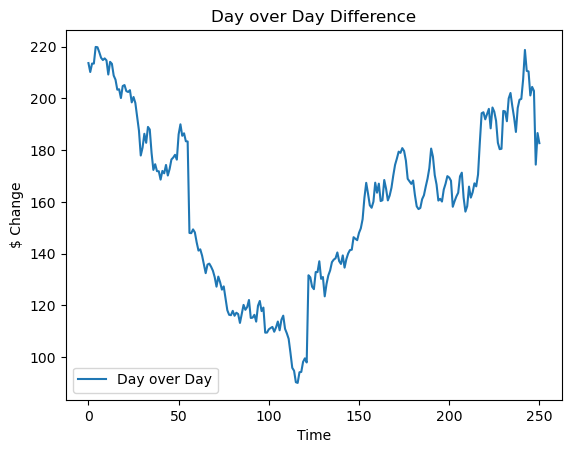

In [6]:
plt.plot(opens, label='Day over Day')
#plt.plot(log_returns, label='Log Returns')
plt.xlabel('Time')
plt.ylabel('$ Change')
plt.title('Day over Day Difference')
plt.legend()

plt.show()

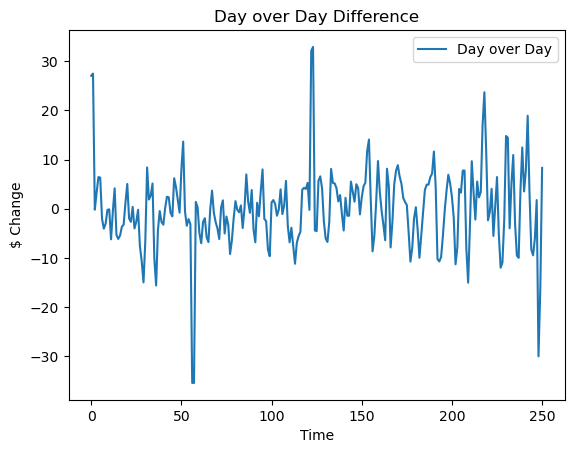

In [7]:
plt.plot(dod_diff, label='Day over Day')
#plt.plot(log_returns, label='Log Returns')
plt.xlabel('Time')
plt.ylabel('$ Change')
plt.title('Day over Day Difference')
plt.legend()

plt.show()


# Calculating a Stocks Volatility
One popular method to calculate the volatility of a stock is the "rolling window" approach, where you calculate the standard deviation of the returns over a specific time period (e.g., 252 trading days per year) and then "roll" the time period forward by one day and repeat the calculation. The formula can be written as follows where S is an array of  historical stock prices:

$$
X = ln(\frac{S_t}{S_{t+1}})
$$
<br />
$$
historical\  volatility = \sqrt{\frac{(X-\mu)^2}{N}} * \sqrt{252}
$$
<br />



Calculate the daily returns of the stock using the pct_change() functi, then calculate the rolling standard deviation of returns using a specified day window size

Source:
https://blog.quantinsti.com/volatility-and-measures-of-risk-adjusted-return-based-on-volatility/

In [8]:
import pandas as pd
#Convert Opens to a dataframe

def calc_volatility(prices, window=50):
    actualdf = pd.DataFrame({'prices':opens})

    #Calcuate Daily Returns
    #actualdf['Returns'] = actualdf['prices'].pct_change()
    actualdf['Returns'] = np.log(actualdf['prices']/actualdf['prices'].shift(1))

    window_size = window
    actualdf['Volatility'] = actualdf['Returns'].rolling(window_size).std() * np.sqrt(window_size)
    
    return actualdf['Volatility'].mean(), actualdf

volatility, actualdf = calc_volatility(opens, 200)

print('Volatility = ' ,volatility)

Volatility =  0.5239271815501957


In [9]:
print(np.std(opens))



32.908228256171


The below is a graph highlighting the calculated historical returns against the calculated volatility

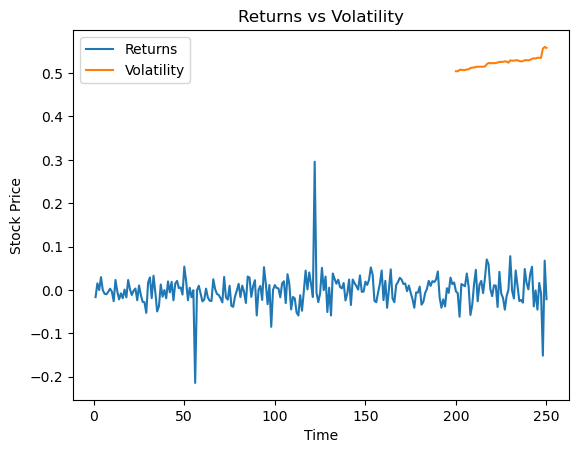

In [10]:
plt.plot(actualdf['Returns'], label='Returns')
plt.plot(actualdf['Volatility'], label='Volatility')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Returns vs Volatility')
plt.legend()

plt.show()

## Calculate a Simple Monte Carlo Simulation
Requires the following Parameters

    open_price - this represents the starting point of the simulation
    sigma - the volatility calculated in the previous step
    r - the risk free rate
    T - the time increment window 1
    N - number of days for the simulation (252 corresponds to the number of trading days in a year )
    M - the number of simulations (i.e. 1000)
    
Use a nested loop to generate random normal variables to simulate the stock price changes. For each simulation (i),iterate through the time steps (j) and calculate the new stock price based on the previous stock price (prices[i,j-1]), the risk-free rate, the volatility (sigma), and a random normal variable (np.random.normal()).

In [11]:
def monte_carlo(open_price, sigma, r, T, N, M):

    # Define the initial stock price, volatility, and time horizon
    price0 = open_price


    # Define the number of time steps and the time increment
    dt = T/N

    # Create a M x N+1 matrix to store the results
    prices = np.zeros((M, N+1))
    prices[:,0] = price0

    # Generate random normal variables to simulate the stock price changes
    for i in range(M):
        for j in range(1, N+1):
            prices[i,j] = prices[i,j-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal())
            
    
    mean_price = np.mean(prices, axis=0)
    
    return prices, mean_price


# Calc monte_carlo sim
T  = 1
N  = 252
dt = T/N
r  = .0339       #https://ycharts.com/indicators/10_year_treasury_rate
M  = 1000

mc_sim_prices, mc_sim_mean = monte_carlo(opens[0], volatility, r, T, N, M)

In [12]:
mc_sim_mean[0]

213.67499999999677

####   Plot Simualtion Results

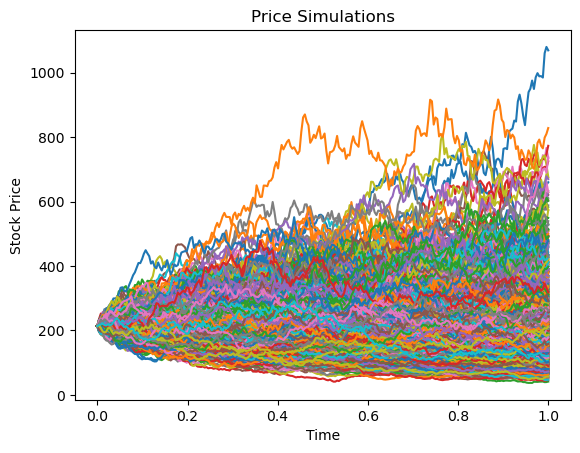

In [13]:
 # Plot the simulated stock prices
plt.plot(np.arange(0, T+dt, dt), mc_sim_prices.T)
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Price Simulations')
plt.show()


## Plot comparison of simulated vs actual prices

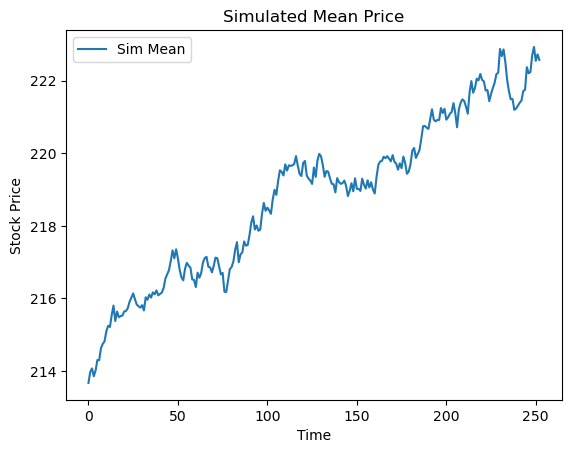

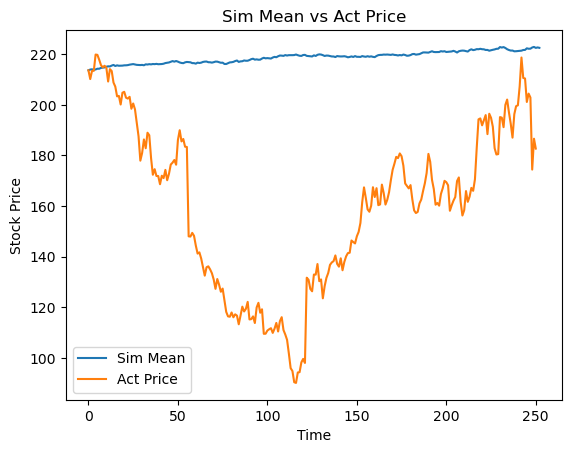

In [14]:
# create a figure with two subplots arranged horizontally
#fig, (ax1, ax2) = plt.subplots(1, 2)


#Plot the simulated mean price
plt.plot(mc_sim_mean, label='Sim Mean')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Simulated Mean Price')
plt.legend()

plt.show()

# Define a weight function for the moving average
weights = np.ones(25) / 25

# Calculate the moving average of the stock price
ma = np.convolve(opens, weights, mode='valid')

#Plot the simulated mean price compared to the Actual
plt.plot(mc_sim_mean, label='Sim Mean')
plt.plot(opens, label='Act Price')
#plt.plot(ma, label='Act Moving Avg')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Sim Mean vs Act Price')
plt.legend()

# adjust the layout of the subplots to prevent overlapping
#fig.tight_layout()

plt.show()


## Plot the Actual vs Simulated Distribution

Actual (mean, var, stddev):  160.19594581673306 1082.9514869602513 32.908228256171
Simulated (mean, var, stddev):  218.80440608796886 5.095732302244564 2.2573728762091045


<function matplotlib.pyplot.show(close=None, block=None)>

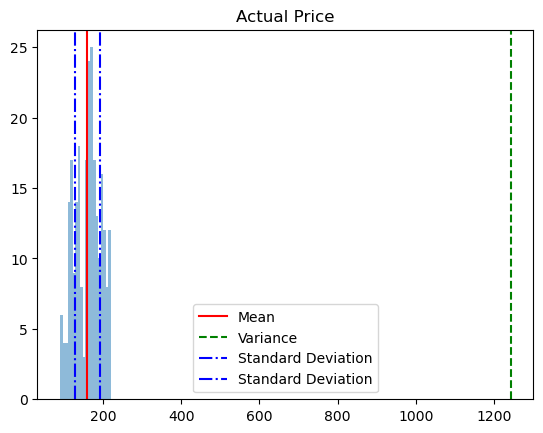

In [15]:
real_mean = np.mean(opens)
real_variance = np.var(opens)
real_std_deviation = np.std(opens)

print('Actual (mean, var, stddev): ',real_mean, real_variance, real_std_deviation)


sim_mean = np.mean(mc_sim_mean)
sim_variance = np.var(mc_sim_mean)
sim_std_deviation = np.std(mc_sim_mean)

print('Simulated (mean, var, stddev): ',sim_mean, sim_variance, sim_std_deviation)

# create a figure with two subplots arranged horizontally
#fig, (hist1, hist2) = plt.subplots(1, 2)

# Plot a histogram of the actual data
plt.hist(opens, bins=20, alpha=0.5)

# Add vertical lines for the mean, variance, and standard deviation
plt.axvline(x=real_mean, color='r', label='Mean')
plt.axvline(x=real_mean+real_variance, color='g', linestyle='--', label='Variance')
plt.axvline(x=real_mean-real_std_deviation, color='b', linestyle='-.', label='Standard Deviation')
plt.axvline(x=real_mean+real_std_deviation, color='b', linestyle='-.', label='Standard Deviation')

# Add legend and show the plot
plt.title('Actual Price')
plt.legend()

plt.show



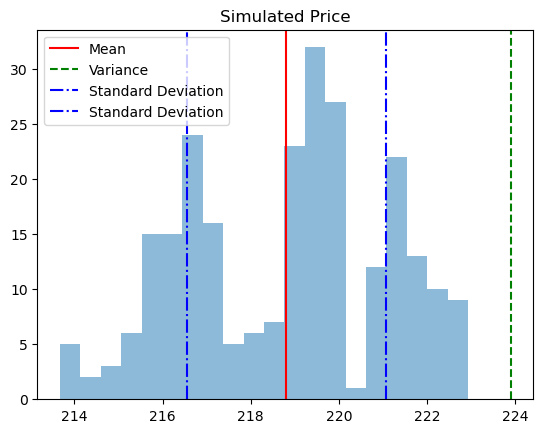

In [16]:
# Plot a histogram of the simulated data
plt.hist(mc_sim_mean, bins=20, alpha=0.5)

# Add vertical lines for the mean, variance, and standard deviation
plt.axvline(x=sim_mean, color='r', label='Mean')
plt.axvline(x=sim_mean+sim_variance, color='g', linestyle='--', label='Variance')
plt.axvline(x=sim_mean-sim_std_deviation, color='b', linestyle='-.', label='Standard Deviation')
plt.axvline(x=sim_mean+sim_std_deviation, color='b', linestyle='-.', label='Standard Deviation')

# Add legend and show the plot
plt.title('Simulated Price')
plt.legend()
plt.show()

## Geometric Brownian Motion calculator
A guide to the notion of securities pricing with code

reference: https://towardsdatascience.com/monte-carlo-pricing-in-python-eafc29e3b6c9

Requires the following Parameters:

    open_price - this represents the starting point of the simulation
    sigma - the volatility calculated above
    drift - calculated above
    T - the time increment window 1
    N - number of days for the simulation (252 corresponds to the number of trading days in a year )
    
This implementation of Geometric Brownian Motion ignore the risk free and introduces the drift variable

In [17]:
class GeometricBrownianMotion:

    def simulate_price(self):
        while(self.T - self.dt > 0):
            dWt = np.random.normal(0, math.sqrt(self.dt))    # Brownian motion
            dYt = self.drift*self.dt + self.volatility*dWt   # Change in price
            self.current_price += dYt                        # Add the change to the current price
            self.prices.append(self.current_price)           # Append new price to series
            self.T -= self.dt                                # Accound for the step in time
            #print(self.T)

    def __init__(self, initial_price, drift, volatility, N, T):
        self.current_price = initial_price
        self.initial_price = initial_price
        self.drift = drift
        self.volatility = volatility
        self.dt = T/N
        self.T = T
        self.prices = []
        self.simulate_price()
        #print(self.dt)

### Execute the Monte Carlo Simualtion using Brownian Motion

In [18]:
# Model Parameters
M = 1000
N = 252
T = 1
bm_prices = np.zeros((M, N+1))
bm_prices[:,0] = opens[0]
price_paths = []

# Generate a set of sample paths
for i in range(0, M):
    #price_paths.append(GeometricBrownianMotion(opens[0], drift, volatility, N, T).prices)
    #bm_prices[i, 1:] = GeometricBrownianMotion(opens[0], .05, volatility, N, T).prices
    bm_prices[i, 1:] = GeometricBrownianMotion(opens[0], real_drift, volatility, N, T).prices

    
    
# Calculate Mean price across all paths
bm_sim_mean = np.mean(bm_prices, axis=0)

## Plot Comaprison of Brownian Motion Simulation to Monte Carlo Simulation

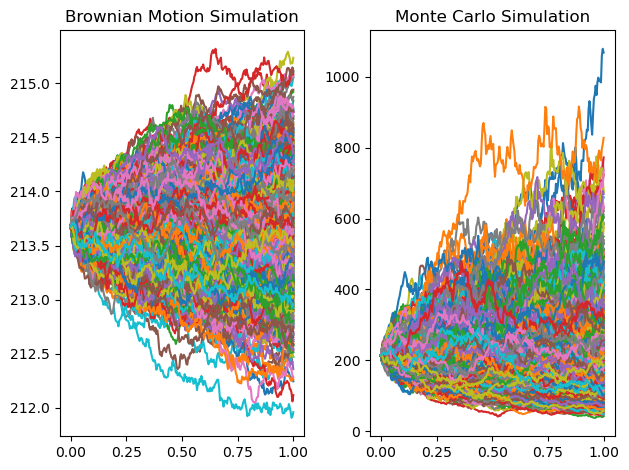

In [20]:
# create a figure with two subplots arranged horizontally
fig, (ax1, ax2) = plt.subplots(1, 2)


#Plot the simulated mean price
ax1.plot(np.arange(0, T+dt, dt), bm_prices.T)
#ax1.set_xlabel('Time')
#ax1.set_ylabel('Stock Price')
ax1.set_title('Brownian Motion Simulation')
#ax1.legend()

#Plot the simulated mean price compared to the Actual
ax2.plot(np.arange(0, T+dt, dt), mc_sim_prices.T)
#ax2.set_xlabel('Time')
#ax2.set_ylabel('Stock Price')
ax2.set_title('Monte Carlo Simulation')


# adjust the layout of the subplots to prevent overlapping
fig.tight_layout()

plt.show()


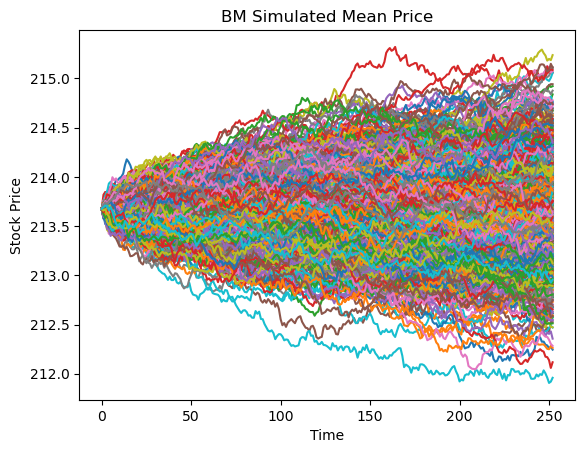

In [21]:
plt.plot(bm_prices.T, label='BM Sim Mean')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('BM Simulated Mean Price')
#plt.legend()
plt.show()

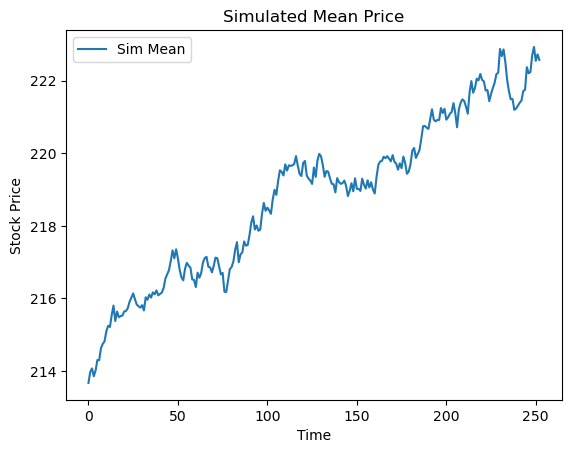

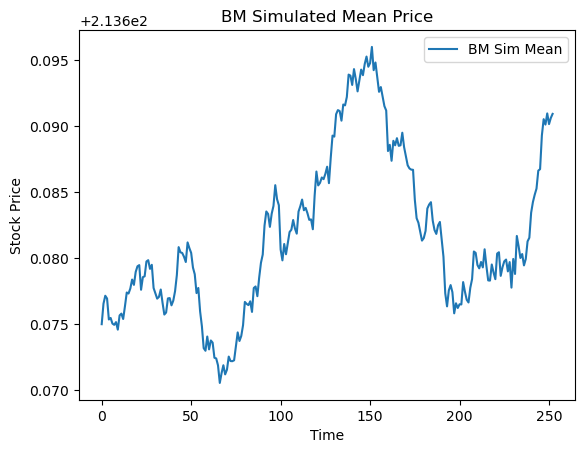

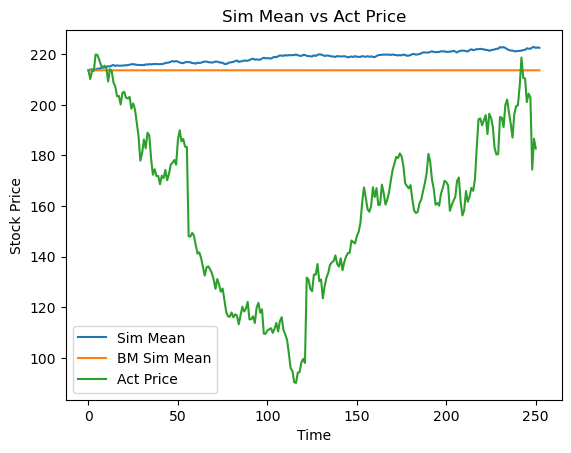

In [22]:

#Plot the simulated mean price
plt.plot(mc_sim_mean, label='Sim Mean')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Simulated Mean Price')
plt.legend()
plt.show()

#Plot the simulated mean price
plt.plot(bm_sim_mean, label='BM Sim Mean')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('BM Simulated Mean Price')
plt.legend()

plt.show()

#Plot the simulated mean price compared to the Actual
plt.plot(mc_sim_mean, label='Sim Mean')
plt.plot(bm_sim_mean, label='BM Sim Mean')
plt.plot(opens, label='Act Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.ticklabel_format(useOffset=False, style='plain')
plt.title('Sim Mean vs Act Price')
plt.legend()

# adjust the layout of the subplots to prevent overlapping
#fig.tight_layout()

plt.show()


### Black Scholes based on Investopedia definition

Reference: https://www.investopedia.com/terms/b/blackscholes.asp

In [40]:
import numpy as np
from scipy.stats import norm

class Black_Scholes:
    
    def d1(S, K, T, r, sigma):
        return (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    
    def d2(S, K, T, r, sigma):
        bs = Black_Scholes
        return (bs.d1(S, K, T, r, sigma) - sigma* np.sqrt(T))

    def call(S, K, T, r, sigma):
        
        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        return S * norm.cdf(d1) - K * np.exp(-r*T)* norm.cdf(d2)

    def put(S, K, T, r, sigma):
        
        d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
        d2 = d1 - sigma* np.sqrt(T)
        
        return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
    
    def __init__(self, ot, S, K, T, r, sigma ):

        
        self.S = S           # Stock Price
        self.K = K           # Strike Price
        self.T = T           # Time To Experiation
        self.r = r           # Risk Free Rate
        self.sigma = sigma   # Volatility 

        if ot.lower() == 'call':
            self.price = black_scholes_call(S, K, T, r, sigma)
        elif ot.lower() == 'put':
            self.price = black_scholes_put(S, K, T, r, sigma)

            
open_prices   = opens[0:248]#np.arange(1, 250,1)
S        = opens[-1]
K        = math.ceil(opens[-1])+1
T        = 1
r        = .0339       #https://ycharts.com/indicators/10_year_treasury_rate
sigma    = volatility #.1736  #volatility  # https://www.barchart.com/stocks/quotes/IBM/volatility-greeks?expiration=2024-01-19-m

bs= Black_Scholes

print(bs.call(S, K, T, r, sigma))
print(bs.put(S, K, T, r, sigma))

39.73854129274669
34.87548395100866


### Calculating Delta

Reference: https://www.codearmo.com/python-tutorial/options-trading-greeks-black-scholes

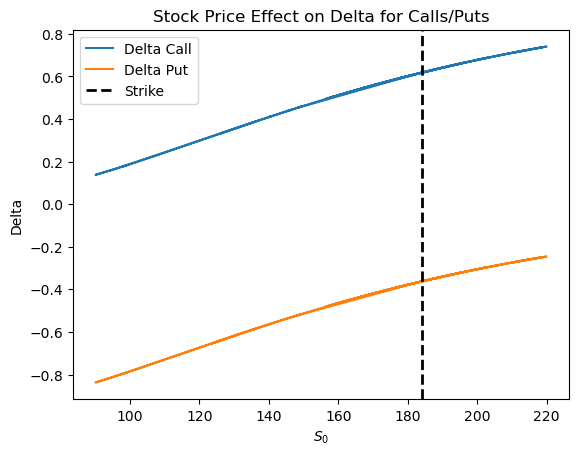

In [41]:
def delta_f_call(S, K, T, r, sigma, ds = .001, method='central'):
    
    method = method.lower() 
    bs= Black_Scholes
    
    if method =='central':
        return (bs.call(S+ds, K, T, r, sigma) - bs.call(S-ds, K, T, r, sigma))/(2*ds)
    elif method == 'forward':
        return (bs.call( S+ds, K, T, r, sigma) - bs.call(S, K, T, r, sigma))/ds
    elif method == 'backward':
        return (bs.call(S, K, T, r, sigma) - bs.call(S-ds, K, T, r, sigma))/ds
    

def delta_f_put(S, K, T, r, sigma, ds = .001, method='central'):
    
    method = method.lower()
    bs= Black_Scholes
    
    if method =='central':
        return (bs.put(S+ds, K, T, r, sigma) - bs.put(S-ds, K, T, r, sigma))/(2*ds)
    elif method == 'forward':
        return (bs.put(S+ds, K, T, r, sigma) - bs.put(S, K, T, r, sigma))/ds
    elif method == 'backward':
        return (bs.put(S, K, T, r, sigma) - bs.put(S-ds, K, T, r, sigma))/ds





call_delta = delta_f_call(open_prices, K, T,r, sigma, ds = 5,method='backward')
put_delta = delta_f_put(open_prices, K, T,r, sigma, ds = 5,method='forward')



#print(call_delta, put_delta)
plt.plot(open_prices, call_delta, label='Delta Call')
plt.plot(open_prices, put_delta, label='Delta Put')
plt.xlabel('$S_0$')
plt.ylabel('Delta')
plt.title('Stock Price Effect on Delta for Calls/Puts' )
plt.axvline(K, color='black', linestyle='dashed', linewidth=2,label="Strike")
plt.legend()

### Calculating Gemma

Reference: https://www.codearmo.com/python-tutorial/options-trading-greeks-black-scholes

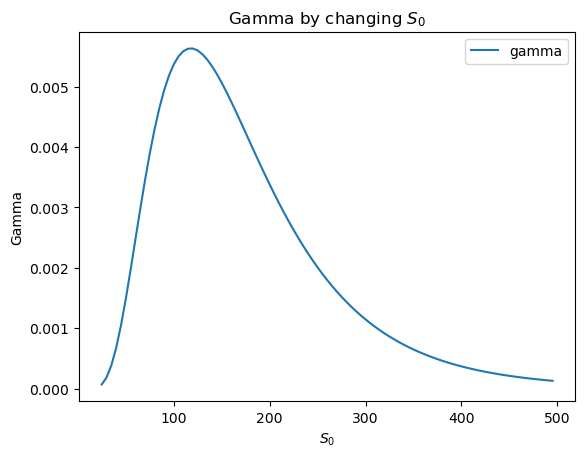

In [43]:
def gamma(S, K, T, r, sigma):
    
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    
    return norm.pdf(d1)/(S*sigma*np.sqrt(T))


def gamma_f_call(S, K, T, r, sigma , ds = .001, method='central'):
    
    method = method.lower() 
    bs= Black_Scholes
    
    if method =='central':
        return (bs.call(S+ds , K, T, r, sigma) - 2*bs.call(S, K, T, r, sigma) + 
                    bs.call(S-ds , K, T, r, sigma) ) / (ds)**2
    elif method == 'forward':
        return (bs.call(S+2*ds, K, T, r, sigma) - 2*bs.call(S+ds, K, T, r, sigma)+
                   bs.call(S, K, T, r, sigma) ) / (ds**2)
    elif method == 'backward':
        return (bs.call(S, K, T, r, sigma) - 2* bs.call(S-ds, K, T, r, sigma)
                + bs.call(S-2*ds,  K, T, r, sigma)) /  (ds**2)  

def gamma_f_put(S, K, T, r, sigma , ds = .001, method='central'):
    
    method = method.lower() 
    bs= Black_Scholes
    
    if method =='central':
        return (bs.put(S+ds , K, T, r, sigma) -2*bs.put(S, K, T, r, sigma) + 
                    bs.put(S-ds , K, T, r, sigma) )/ (ds)**2
    elif method == 'forward':
        return (bs.put('put', S+2*ds, K, T, r, sigma) - 2*bs.put(S+ds, K, T, r, sigma) +
                   black_scholes_call(S, K, T, r, sigma) )/ (ds**2)
    elif method == 'backward':
        return (bs.put(S, K, T, r, sigma) - 2* bs.put(S-ds, K, T, r, sigma)
                + bs.put(S-2*ds,  K, T, r, sigma)) /  (ds**2)  
    
Ks = np.arange(25, 500, 5)    
gammas = gamma(Ks, K, T, r, sigma)
gamma_forward =  gamma_f_call(Ks, K, T, r, sigma, ds =0.01,method='forward')
gamma_central =  gamma_f_call(Ks, K, T, r, sigma, ds =0.01,method='central')
gamma_backward = gamma_f_call(Ks, K, T, r, sigma, ds =0.01,method='backward')


#Ks = np.arange(25, 225, 5)
plt.plot(Ks, gammas, label='gamma')
#plt.plot(Ks, gamma_forward, label='gamma forward')
#plt.plot(Ks, gamma_central, label='gamma central')
#plt.plot(Ks, gamma_backward, label='gamma backward')
plt.title('Gamma by changing $S_0$')
plt.xlabel('$S_0$')
plt.ylabel('Gamma')
plt.legend()

### Calculating Vega
Source: https://www.codearmo.com/python-tutorial/options-trading-greeks-black-scholes

## Creating the Greeks Library

In [73]:
class TheGreeks:
    
    
    def delta_f_call(S, K, T, r, sigma, ds = .001, method='central'):
    
        method = method.lower() 
        bs= Black_Scholes
    
        if method =='central':
            return (bs.call(S+ds, K, T, r, sigma) - bs.call(S-ds, K, T, r, sigma))/(2*ds)
        elif method == 'forward':
            return (bs.call( S+ds, K, T, r, sigma) - bs.call(S, K, T, r, sigma))/ds
        elif method == 'backward':
            return (bs.call(S, K, T, r, sigma) - bs.call(S-ds, K, T, r, sigma))/ds
    

    def delta_f_put(S, K, T, r, sigma, ds = .001, method='central'):
    
        method = method.lower()
        bs= Black_Scholes
    
        if method =='central':
            return (bs.put(S+ds, K, T, r, sigma) - bs.put(S-ds, K, T, r, sigma))/(2*ds)
        elif method == 'forward':
            return (bs.put(S+ds, K, T, r, sigma) - bs.put(S, K, T, r, sigma))/ds
        elif method == 'backward':
            return (bs.put(S, K, T, r, sigma) - bs.put(S-ds, K, T, r, sigma))/ds
    
    def gamma(S, K, T, r, sigma):
    
        bs = Black_Scholes
        d1 = bs.d1(S, K, T, r, sigma)
    
        return norm.pdf(d1)/(S*sigma*np.sqrt(T))


    def gamma_f_call(S, K, T, r, sigma , ds = .001, method='central'):
    
        method = method.lower() 
        bs= Black_Scholes
    
        if method =='central':
            return (bs.call(S+ds , K, T, r, sigma) - 2*bs.call(S, K, T, r, sigma) + 
                    bs.call(S-ds , K, T, r, sigma) ) / (ds)**2
        elif method == 'forward':
            return (bs.call(S+2*ds, K, T, r, sigma) - 2*bs.call(S+ds, K, T, r, sigma)+
                   bs.call(S, K, T, r, sigma) ) / (ds**2)
        elif method == 'backward':
            return (bs.call(S, K, T, r, sigma) - 2* bs.call(S-ds, K, T, r, sigma)
                + bs.call(S-2*ds,  K, T, r, sigma)) /  (ds**2)  

    def gamma_f_put(S, K, T, r, sigma , ds = .001, method='central'):
    
        method = method.lower() 
        bs= Black_Scholes
    
        if method =='central':
            return (bs.put(S+ds , K, T, r, sigma) -2*bs.put(S, K, T, r, sigma) + 
                    bs.put(S-ds , K, T, r, sigma) )/ (ds)**2
        elif method == 'forward':
            return (bs.put('put', S+2*ds, K, T, r, sigma) - 2*bs.put(S+ds, K, T, r, sigma) +
                   black_scholes_call(S, K, T, r, sigma) )/ (ds**2)
        elif method == 'backward':
            return (bs.put(S, K, T, r, sigma) - 2* bs.put(S-ds, K, T, r, sigma)
                + bs.put(S-2*ds,  K, T, r, sigma)) /  (ds**2)  
    
    
    def vega_f_call(S, K, T, r, sigma, dv=1e-4, method='central'):
    
        method = method.lower() 
        bs= Black_Scholes
    
        if method =='central':
            return (bs.call(S, K, T, r, sigma+dv) - bs.call(S, K, T, r, sigma-dv))/(2*dv)
        elif method == 'forward':
            return (bs.call(S, K, T, r, sigma+dv) - bs.call(S, K, T, r, sigma))/dv
        elif method == 'backward':
            return (BS_CALL(S, K, T, r, sigma) - bs.call(S, K, T, r, sigma-dv))/dv

    def vega_f_put(S, K, T, r, sigma, dv=1e-4, method='central'):
        
        method = method.lower()
        bs= Black_Scholes
        
        if method =='central':
            return (bs.put(S, K, T, r, sigma+dv) - bs.put(S, K, T, r, sigma-dv))/(2*dv)
        elif method == 'forward':
            return (bs.put(S, K, T, r, sigma+dv) - bs.put(S, K, T, r, sigma))/dv
        elif method == 'backward':
            return (bs.put(S, K, T, r, sigma) - bs.put(S, K, T, r, sigma-dv))/dv
        
        
    def theta_call(S, K, T, r, sigma):
        bs= Black_Scholes
        p1 = -S * norm.pdf(bs.d1(S, K, T, r, sigma)) * sigma  / (2 * np.sqrt(T))
        p2 = r*K*np.exp(-r*T)*norm.cdf(bs.d2(S, K, T, r, sigma)) 
        return p1 - p2
    

    def theta_put(S, K, T, r, sigma):
        bs= Black_Scholes
        p1 = -S * norm.pdf(bs.d1(S, K, T, r, sigma)) * sigma / (2 * np.sqrt(T))
        p2 = r * K * np.exp(-r*T) * norm.cdf(-bs.d2(S, K, T, r, sigma)) 
        return p1 + p2
    
    def rho_call(S, K, T, r, sigma):
        bs= Black_Scholes
        return K* T * np.exp(-r*T) * norm.cdf(bs.d2(S, K, T, r, sigma))

    def rho_put(S, K, T, r, sigma):
        bs= Black_Scholes
        return -K* T * np.exp(-r*T) * norm.cdf(-bs.d2(S, K, T, r, sigma))
    
    def __init__(self, ot, S, K, T, r, sigma ):
        self.S = S           # Stock Price
        self.K = K           # Strike Price
        self.T = T           # Time To Experiation
        self.r = r           # Risk Free Rate
        self.sigma = sigma   # Volatility 

## Calculate call and put price table

Running for IBM and comparing to January 2024 expiration based on information found here: <br /> 
    https://www.barchart.com/stocks/quotes/IBM/volatility-greeks?expiration=2024-01-19-m <br />
    https://bigcharts.marketwatch.com/quickchart/options.asp?symb=IBM

In [74]:
current_price     = opens[1]
bottom_range      = math.floor(current_price)-25.0
top_range         = math.ceil(current_price)+25.0
sigma             = .1736  #volatility  # https://www.barchart.com/stocks/quotes/IBM/volatility-greeks?expiration=2024-01-19-m
r                 = .0339       #https://ycharts.com/indicators/10_year_treasury_rate
T                 = 287/365 #(datetime(2024,1,19) - datetime.today()).days/365
spc               = []
bs                = Black_Scholes
greek             = TheGreeks

Kp = bottom_range
step = 2.5 

while Kp <= top_range:
    spc.append([float(Kp), 
                float("{:.{}f}".format(bs.call(current_price, Kp, T, r, sigma), 3)),
                float("{:.{}f}".format(greek.delta_f_call(current_price, Kp, T, r, sigma, ds = 5,method='backward'), 3)),
                float("{:.{}f}".format(greek.gamma_f_call(current_price, Kp, T, r, sigma), 3)),
                float("{:.{}f}".format(greek.vega_f_call(current_price, Kp, T, r, sigma), 3)),
                float("{:.{}f}".format(greek.theta_call(current_price, Kp, T, r, sigma), 3)),
                float("{:.{}f}".format(greek.rho_call(current_price, Kp, T, r, sigma), 3)),
                float("{:.{}f}".format(bs.put(current_price, Kp, T, r, sigma), 3)),
                float("{:.{}f}".format(greek.delta_f_put(current_price, Kp, T, r, sigma, ds = 5,method='forward'), 3)),
                float("{:.{}f}".format(greek.gamma_f_put(current_price, Kp, T, r, sigma), 3)),
                float("{:.{}f}".format(greek.vega_f_put(current_price, Kp, T, r, sigma), 3)),
                float("{:.{}f}".format(greek.theta_put(current_price, Kp, T, r, sigma), 3)),
                float("{:.{}f}".format(greek.rho_put(current_price, Kp, T, r, sigma), 3))
               ])
    Kp += step

columns = ['StrikePrice', 'Call','CallDelta', 'CallGemma', 'CallVega','CallTheta','CallRho', 'Put', 'PutDelta', 'PutGemma', 'PutVega','PutTheta','PutRho']
option_prices = pd.DataFrame(spc, columns=columns)
print(option_prices)

    StrikePrice    Call  CallDelta  CallGemma  CallVega  CallTheta  CallRho  \
0         185.0  32.553      0.842      0.007    41.502     -9.606  116.541   
1         187.5  30.578      0.820      0.008    45.427     -9.961  114.733   
2         190.0  28.663      0.796      0.008    49.296    -10.297  112.625   
3         192.5  26.810      0.771      0.009    53.050    -10.608  110.228   
4         195.0  25.023      0.745      0.009    56.634    -10.889  107.556   
5         197.5  23.303      0.718      0.010    59.995    -11.134  104.627   
6         200.0  21.655      0.690      0.010    63.084    -11.338  101.463   
7         202.5  20.078      0.661      0.011    65.858    -11.499   98.088   
8         205.0  18.575      0.631      0.011    68.280    -11.613   94.527   
9         207.5  17.146      0.601      0.012    70.319    -11.678   90.810   
10        210.0  15.792      0.571      0.012    71.954    -11.692   86.965   
11        212.5  14.513      0.541      0.012    73.

In [77]:
option_prices.loc[:, ['StrikePrice','Call','CallDelta', 'CallGemma', 'CallVega','CallTheta','CallRho']].to_csv('call_chain.csv', index=False)
option_prices.loc[:, ['StrikePrice', 'Put','PutDelta', 'PutGemma', 'PutVega','PutTheta','PutRho']].to_csv('put_chain.csv', index=False)